# Scraping Data Analyst Jobs on Indeed

In [163]:
import requests
from bs4 import BeautifulSoup
import math
import pandas as pd
from matplotlib import pyplot as plt

### Data Scraping

In [164]:
def get_soup(url, page_number, headers):
    page = requests.get(url + str(page_number), headers)
    soup = BeautifulSoup(page.content, 'html.parser')
    return soup

In [165]:
def scrape_jobs(soup):

    title_list = []
    company_list = []
    location_list = []

    divs = soup.find_all('div', class_ = 'job_seen_beacon')

    for element in divs:
        try:
            title = element.find('h2', class_ = 'jobTitle').text   
        except:
            title = 'No Title'

        try:
            company = element.find('span', class_ = 'companyName').text
        except:
            company = 'No Company'

        try:
            location = element.find('div', class_ = 'companyLocation').text
        except:
            location = 'No Location'

        title_list.append(title)
        company_list.append(company)
        location_list.append(location)

    jobs = pd.DataFrame({
        'title' : title_list,
        'company' : company_list,
        'location' : location_list
    })

    return jobs

In [166]:
def data_extraction(url, headers):
    
    total_number_of_jobs = get_soup(url, 0, headers).find('div', {'id' : 'searchCountPages'}).text.strip()

    try:
        total_number_of_jobs = int(total_number_of_jobs[10:].replace(' jobs', ''))
    except:
        try:
            total_number_of_jobs = int(total_number_of_jobs.replace(' jobs', ''))
        except:
            try:
                total_number_of_jobs = int(total_number_of_jobs[:4])
            except:
                try:
                    total_number_of_jobs = int(total_number_of_jobs[:3])
                except:
                    try:
                        total_number_of_jobs = int(total_number_of_jobs[:2])
                    except:
                        print('---------------------------------------------------------------')
                        print(f'total_number_of_jobs = {total_number_of_jobs}')
                        print('---------------------------------------------------------------')
        
    number_of_pages = math.ceil(total_number_of_jobs/15)
    
    data = pd.DataFrame()

    for i in range(number_of_pages):
        soup = get_soup(url, i * 10, headers)
        jobs = scrape_jobs(soup)
        data = pd.concat([data, jobs], ignore_index=True)

    return data

In [167]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
data_analyst_query = 'https://ie.indeed.com/jobs?q=%22data%20analyst%22&start='    
sql_query = 'https://ie.indeed.com/jobs?q=%22data%20analyst%22%20AND%20sql&start='
python_query = 'https://ie.indeed.com/jobs?q=%22data%20analyst%22%20AND%20python&start='
excel_query = 'https://ie.indeed.com/jobs?q=%22data%20analyst%22%20AND%20excel&start='
tableau_query = 'https://ie.indeed.com/jobs?q=%22data%20analyst%22%20AND%20tableau&start='
powerbi_query = 'https://ie.indeed.com/jobs?q=%22data%20analyst%22%20AND%20power%20bi&start='

In [168]:
data_analyst_df = data_extraction(data_analyst_query, headers)
python_df = data_extraction(sql_query, headers)
excel_df = data_extraction(python_query, headers)
sql_df = data_extraction(excel_query, headers)
powerbi_df = data_extraction(tableau_query, headers)
tableau_df = data_extraction(powerbi_query, headers)

### Data Cleaning

##### Standardizing values

In [169]:
data_analyst_df['location'] = data_analyst_df['location'].str.split(', ').str[1]

location_group = data_analyst_df.groupby(['location']).size()
most_common_location = location_group.idxmax()

#### Checking for null values and replacing with default

In [170]:
if data_analyst_df['title'].isnull().sum() != 0:
    data_analyst_df['title'].fillna('Data Analyst', inplace=True)

if data_analyst_df['company'].isnull().sum() != 0:
    data_analyst_df['company'].fillna('No Company', inplace=True)

if data_analyst_df['location'].isnull().sum() != 0:
    data_analyst_df['location'].fillna(most_common_location, inplace=True)

#### Checking for duplicates and deleting them

In [171]:
data_analyst_df.drop_duplicates(subset=['title', 'company', 'location'], keep='first', inplace=True)
python_df.drop_duplicates(subset=['title', 'company', 'location'], keep='first', inplace=True)
excel_df.drop_duplicates(subset=['title', 'company', 'location'], keep='first', inplace=True)
sql_df.drop_duplicates(subset=['title', 'company', 'location'], keep='first', inplace=True)
powerbi_df.drop_duplicates(subset=['title', 'company', 'location'], keep='first', inplace=True)
tableau_df.drop_duplicates(subset=['title', 'company', 'location'], keep='first', inplace=True)

#### Creating id column for data_analyst_df dataframe

In [172]:
data_analyst_df.insert(0, 'id', (data_analyst_df.index + 1).to_list())

#### Creating skills dataframe

In [173]:
skills_df = pd.DataFrame({
    'id' : [1, 2, 3, 4, 5],
    'skill' : ['Python', 'Excel', 'SQL', 'PowerBI', 'Tableau'],
    'quantity' : [len(python_df), len(excel_df), len(sql_df), len(powerbi_df), len(tableau_df)]
})

### Data Visualization

##### How many Data Analyt jobs are in Ireland by location ?

In [174]:
jobs_by_location_df = pd.DataFrame({
        'location' : list(data_analyst_df.groupby(['location']).size().keys()),
        'job_by_location' : list(data_analyst_df.groupby(['location']).size().values)
    })

In [175]:
jobs_by_location_df

,location,job_by_location
0,County Clare,2
1,County Cork,11
2,County Donegal,1
3,County Dublin,114
4,County Galway,3
5,County Kildare,1
6,County Limerick,4
7,County Longford,1
8,County Offaly,1
9,County Westmeath,1


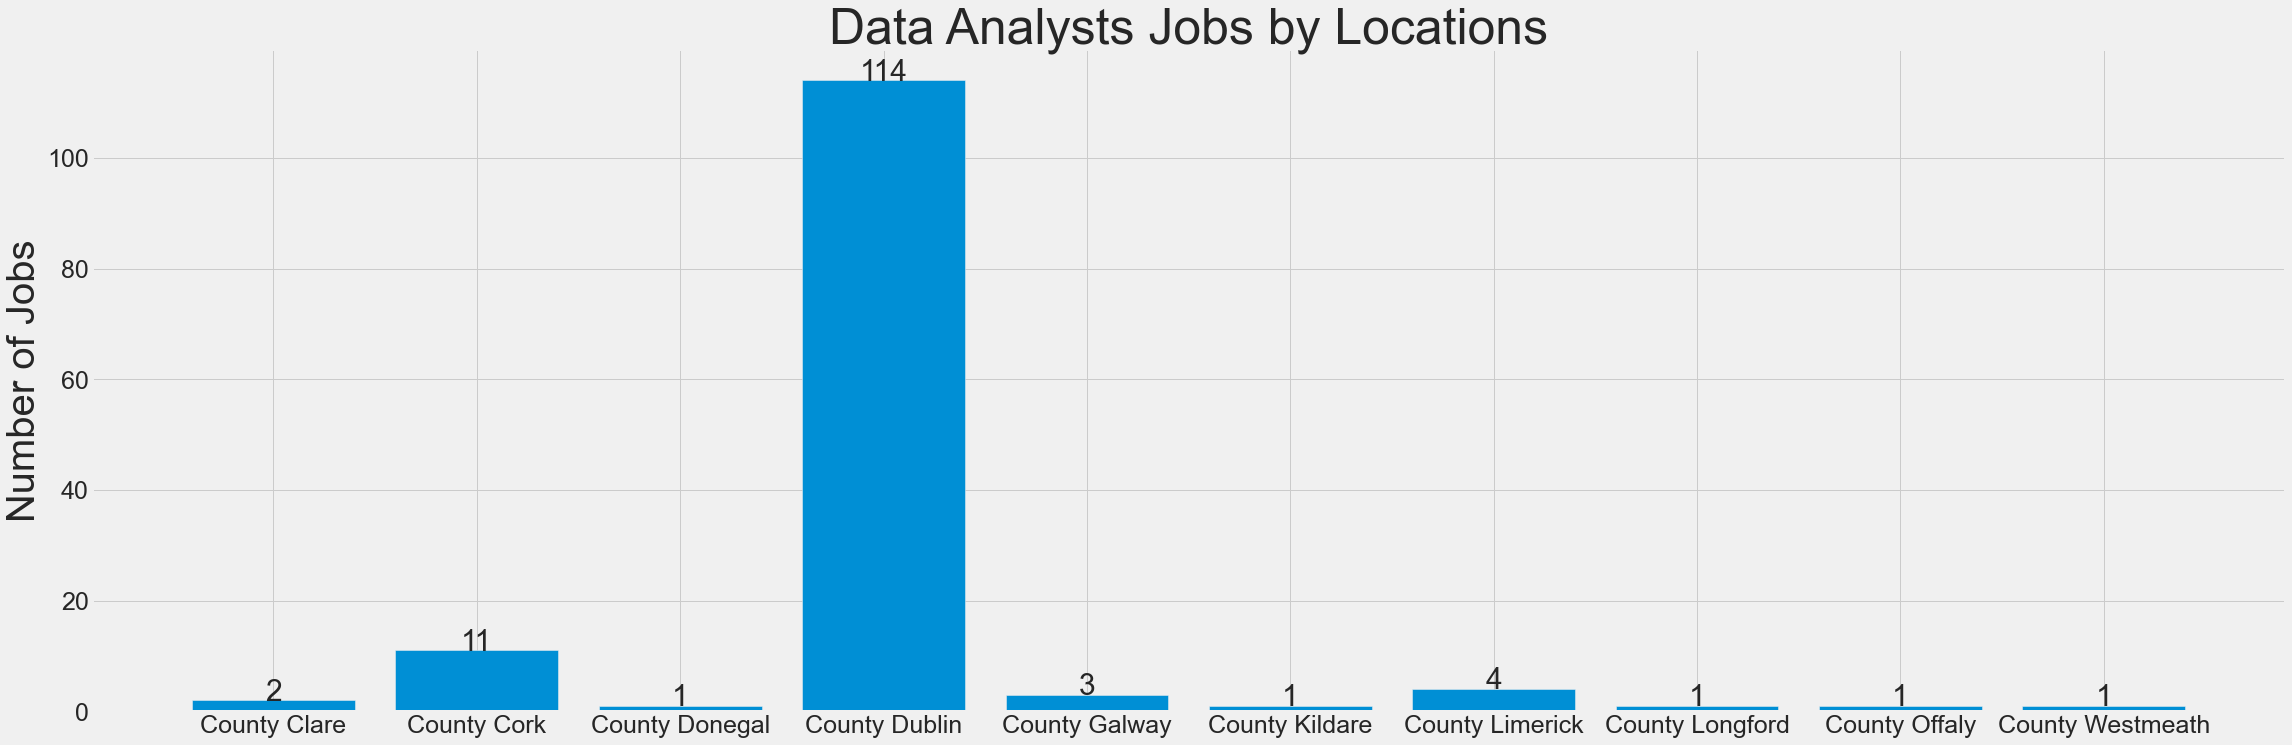

In [177]:
x = jobs_by_location_df['location']
y = jobs_by_location_df['job_by_location']

plt.figure(figsize=(35, 10))
plt.bar(x, y)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Data Analysts Jobs by Locations', fontsize=50)
plt.ylabel('Number of Jobs', fontsize=40)
plt.tight_layout()

for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', fontsize=30)

##### What are the most requested technical skills in Data Analyst jobs ?

In [197]:
skills_df

,id,skill,quantity
0,1,Python,76
1,2,Excel,50
2,3,SQL,61
3,4,PowerBI,51
4,5,Tableau,27


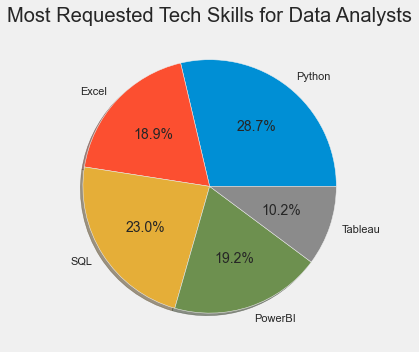

In [196]:
slices = skills_df['quantity']
labels = skills_df['skill']

plt.figure(figsize=(5, 5))
plt.pie(slices, labels=labels, shadow=True, autopct='%1.1f%%') 
plt.title('Most Requested Tech Skills for Data Analysts')
plt.tight_layout()
